I want to be able to reason about the efficiency of a quantum error correction code.

A code $\mathcal{C}$ is given by $\{|L_0)\rangle, |L_1\rangle\}$ such that $\langle L_0 | L_1 \rangle = 0$.

An error correction code will be more or less efficient depending on the number of errors it can detect/correct and the number of qubits it uses.

Additionally, an error correction code will require translating all algorithm instructions into the code's basis. This translation requires:

1. Encode and decode instructions.

2. A set of instructions for syndrome detections. These typically involve a series of controlled-U gates; conditioned on the state qubit and acting on the ancilla qubit. A measurement is used to project the continuous errors into a discrete syndrome. Non-conventional stabilizer ancillas may use other gates, for example, erasure detection using an iSWAP.

3. A set of instructions for the correction procedure conditioned on the syndrome. This likely involves resetting the faulty qubit and reapplying the encoding procedure.

4. A set of logical operators to perform the algorithm computation with. A logical operation can be created by
   \begin{align}
   A = |L_0\rangle\langle0| + |L_1\rangle\langle1| \\
   U' = A U A^\dagger
   \end{align}
   where $U$ is a unitary that acts on the $|0\rangle$ and $|1\rangle $ states.
   We can also describe a logical operator as a centralizer to the stabilizer group.

   This is interesting because it complicates the research question we answered in previous work, regarding most efficient basis gate. Here, efficient hardware computational operations don't necessary create efficient logical operations. More, we will be limited by qubit connectivity as we will need connections between two logical qubit's state qubits in order to perform a logical operation.

5. A procedure for interleaving syndrome measurements and logical operations. Simply, we might choice to check for faults between every logical operation, or we might choice to check for faults after every $n$ logical operations. Moreover, depending on the construction of the code, we might be able to check for syndrome in parallel with the logical operation (for example, if syndrome check commutes with the logical operation), or if can be done in parallel with the other syndrome checks (this might not be possible if the syndrome checks leave the codespace for example).
   If the syndrome checks cannot be done in parallel, we might not need unique ancilla qubits for each syndrome check.

6. We should consider the efficiency of the code with regards to a specific error model. In particular, we should be able to characterize a system's error channels and gate fidelities in order to determine the best error correction code for that system Operator-sum representation of an error channel:

\begin{align}
\epsilon(\rho) = \sum_i E_i \rho E_i^\dagger
\end{align}

Use the error channel to create noisy-operators.

\begin{align}
U' = \sum_i E_i U
\end{align}

We can verify that the codespace meets minimum requirements for the given error channels. Suppose $\Epsilon$ is quantum operation with operation elements ${E_i}$. A necessary and sufficient condition for the existence of an error-correction operation $R$ correcting $\Epsilon$ on $\mathcal{C}$ is that
\begin{align}
P E^\dagger*i E_j P = \alpha*{ij} P
\end{align}
, for some Hermitian matrix $\alpha$ of complex numbers.

In order to evaluate the large sets of tradeoffs, we need to describe the syndrome, correction, and logical operators in terms of circuit costs. If the code protects errors efficiently, but in practice the operators are too expensive too implement on our hardware (after decomposing into hardware basis gates), then the code is not useful. We need information about how the hardware in order to determine a more accurate expected **increase in effective qubit fidelities**.

7. We might choice to enforce rules that continuous operators may not leave the codespace, otherwise this may lead to undectable faults. However, if doing so gives us an otherwise more efficient operation we might find it worthwhile.

8. We should be able to analyze the efficiency analytically to some extent. For example, given an error channel in terms of symbolic parameters, we can write the expected error of a gate, or the average/worst case state fidelity following the gate. We can use these to determine how faulty each logical operation is, as well as how faulty the syndrome and correction steps are themselves. We can use this to predict how often we need to check for faults and use a Markov chain to determine probabilities we end up remaining in the codespace for a given number of logical operations.

9. Given a fault map and qubit connectivity, we should be able to analyze the efficiency from sets of error codes. We should integrate the transformations into a transpiler pass which will insert the error correction circuity into the circuit and be able to run the circuit on a simulator or real device.


In [175]:
# explicit tutorial on the encoding
# what gates do encoding and detection
# the known solutions are the 5-wave and parallel 3-wave
# (we don't know if there exists others yet)
# but we need to first be able to simulate the faults and effective increases in lifetimes
# if that the qubits had lifetimes and errro channels
import numpy as np
from IPython.display import display, Math

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
,where U is unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


In [117]:
from quantum_logical.basis import SNAILConcatWithAncilla

encoding = SNAILConcatWithAncilla()
A = encoding.logical_basis.transform_operator
A

Quantum object: dims = [[3, 3, 3], [2]], shape = (27, 2), type = oper, isherm = False
Qobj data =
[[ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]]

In [118]:
encoding.detection_operator

Quantum object: dims = [[54, 54], [54, 54]], shape = (2916, 2916), type = oper, isherm = True
Qobj data =
[[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.5  0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.5  0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]

In [119]:
from quantum_logical.conversiongain import (
    ConversionGainThreeWave,
    ConversionGainThreeWaveTwo,
    ConversionGainFiveWave,
)

H = ConversionGainThreeWave(gc=np.pi / 2, gg=0, transmon_levels=3)
display(Math(str(H)))
U1 = H.unitary(t=1.0)
print(U1)

<IPython.core.display.Math object>

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [120]:
H = ConversionGainThreeWaveTwo(gc=np.pi / 2, gg=0, transmon_levels=3)
display(Math(str(H)))
U2 = H.unitary(t=1.0)
print(U2)

<IPython.core.display.Math object>

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [121]:
# looks like multiplying the two unitaries does not give the same result as the 5-wave
U1 * U2

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]]

![Alt text](../../images/image.png)


In [180]:
# what if we don't just compose the unitaries but put all the terms into the Hamiltonian?
from quantum_logical.conversiongain import ConversionGainThreeWaveTogether

H = ConversionGainThreeWaveTogether(
    gc=np.pi / 2,
    gg=0,
    phi_c1=-0.5 * np.pi,
    phi_c2=0 * np.pi,
    transmon_levels=3,
)
U3 = H.unitary(t=np.sqrt(2))
U3

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]

In [123]:
# from qutip import Qobj
# Qobj(H.construct_H().H.full())

In [181]:
H = ConversionGainFiveWave(gc=np.pi / 2, gg=0)
U = H.unitary(t=1.0)
U

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

In [125]:
from qutip import Qobj

Qobj(H.construct_H().H.full())

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.57079633 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.57079633 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]

In [126]:
# todo, check decode solution with 3-, 5-wave gates
# show that 5-wave stays in encoding, 3-wave does not
# is_centralizer()

In [135]:
from quantum_logical.basis import PhaseReptition
from qiskit.quantum_info import StabilizerState
from qutip import basis

encoding = PhaseReptition()

In [144]:
from qiskit.quantum_info import Statevector, Operator, Clifford

op = encoding.logical_basis.zero_ket
op

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.35355339]
 [0.35355339]
 [0.35355339]
 [0.35355339]
 [0.35355339]
 [0.35355339]
 [0.35355339]
 [0.35355339]]

In [174]:
from qiskit.circuit.library import XGate, IGate, ZGate
from qutip import tensor

x = tensor(
    Qobj(ZGate().to_matrix()),
    Qobj(XGate().to_matrix()),
    Qobj(IGate().to_matrix()),
)
x * op

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [-0.35355339]
 [-0.35355339]
 [-0.35355339]
 [-0.35355339]]

In [156]:
sv = Statevector(op.full())
sv

Statevector([0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
             0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
             0.35355339+0.j, 0.35355339+0.j],
            dims=(2, 2, 2))


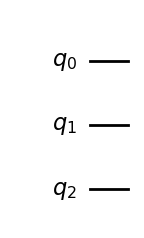

In [137]:
from qiskit import transpile

transpile(qc, basis_gates=["u", "cx"], optimization_level=1).draw(output="mpl")

In [138]:
encoding.logical_basis.zero_ket.full()

array([[0.35355339+0.j],
       [0.35355339+0.j],
       [0.35355339+0.j],
       [0.35355339+0.j],
       [0.35355339+0.j],
       [0.35355339+0.j],
       [0.35355339+0.j],
       [0.35355339+0.j]])

In [139]:
from qiskit import QuantumCircuit

qc1 = QuantumCircuit(3)
# qc.x(0)
qc1.cx(0, 1)
qc1.cx(0, 2)
qc1.h(0)
qc1.h(1)
qc1.h(2)
stab = StabilizerState(qc1)
stab

StabilizerState(StabilizerTable: ['+IIX', '+IXX', '+XIX'])

In [140]:
from qiskit import QuantumCircuit

qc2 = QuantumCircuit(3)
qc2.x(0)
qc2.cx(0, 1)
qc2.cx(0, 2)
qc2.h(0)
qc2.h(1)
qc2.h(2)
stab = StabilizerState(qc2)
stab

StabilizerState(StabilizerTable: ['-IIX', '+IXX', '+XIX'])

In [141]:
stab

StabilizerState(StabilizerTable: ['-IIX', '+IXX', '+XIX'])

In [142]:
from qiskit.quantum_info.operators import Clifford

Clifford(qc2).to_labels()

['+ZZZ', '+IZI', '+ZII', '-IIX', '+IXX', '+XIX']

In [143]:
from qiskit.quantum_info import Statevector

state = Statevector(qc)